All the necessary imports are made below

In [9]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader ,random_split
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#path to my dataset folder
dataset_path = '../../../tsr/data/Train'

In [3]:
#classes will store list of class present in my training data
classes = os.listdir(dataset_path)

In [4]:
num_classes = len(classes)
num_classes

43

Visualizing the data

In [14]:
num_images_to_display = 5

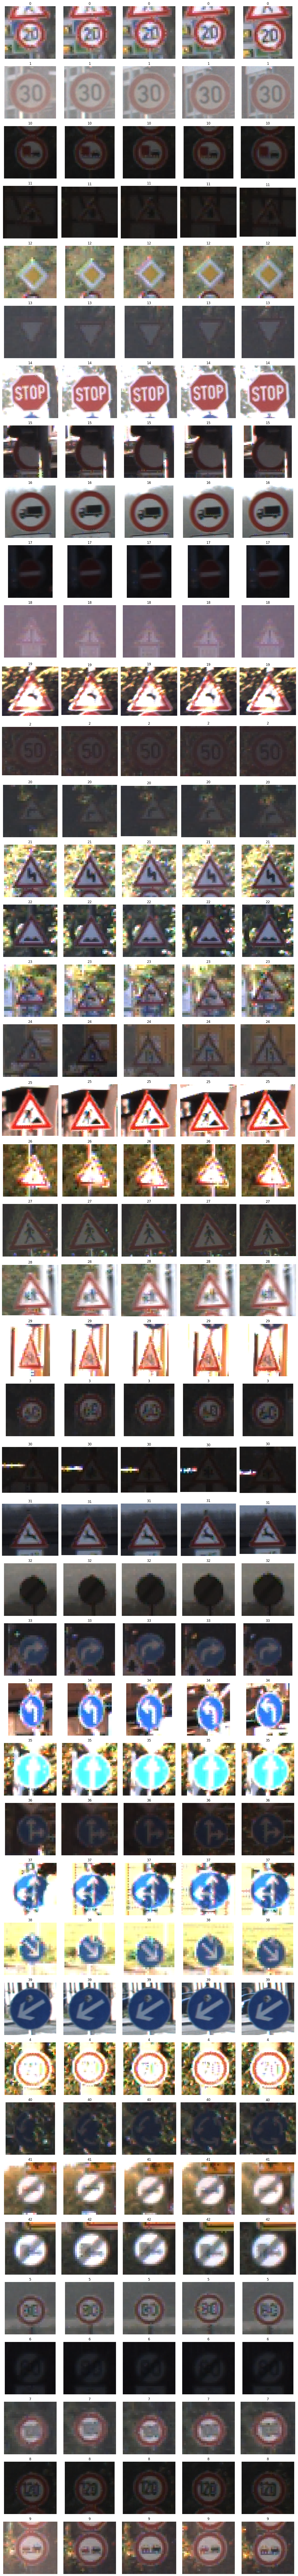

In [15]:
fig, axes = plt.subplots(num_classes, num_images_to_display, figsize=(15, 3 * num_classes))

for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)  # Get the list of images in the class folder

    # Select the first five images (or fewer if there are not enough images)
    for j in range(min(num_images_to_display, len(image_files))):
        image_path = os.path.join(class_path, image_files[j])
        img = Image.open(image_path)
        
        # Display the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Hide the axis
        axes[i, j].set_title(class_name)  # Set the title to the class name

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
num_epochs = 10
batch_size = 32
learning_rate = 0.01

Bar graph to check distribution of dataset images in different classes 

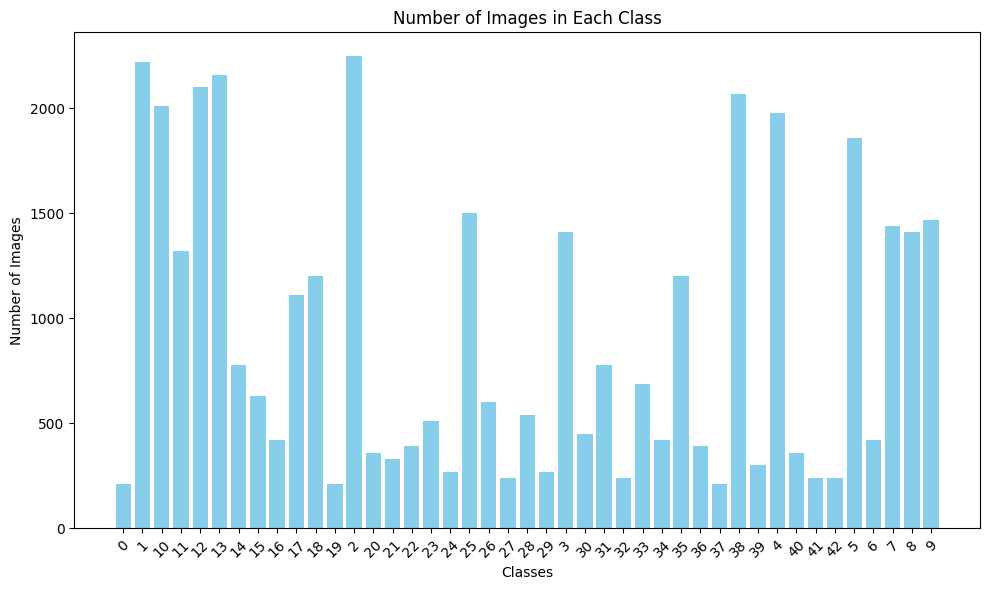

In [20]:
num_images_per_class = []

# Iterate over each class to count the number of images
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    # Count the number of image files in the class directory
    num_images = len(os.listdir(class_path))
    num_images_per_class.append(num_images)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(classes, num_images_per_class, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout
plt.show()

In [ ]:
# Initialize lists to hold width and height of images
widths = []
heights = []

# Iterate over each class to gather image dimensions
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            widths.append(img.width)
            heights.append(img.height)

# Convert lists to numpy arrays for easier calculations
widths = np.array(widths)
heights = np.array(heights)

# Calculate average width and height
average_width = int(np.mean(widths))
average_height = int(np.mean(heights))

# Calculate the most common size
unique_widths, counts_widths = np.unique(widths, return_counts=True)
most_common_width = unique_widths[np.argmax(counts_widths)]

unique_heights, counts_heights = np.unique(heights, return_counts=True)
most_common_height = unique_heights[np.argmax(counts_heights)]

# Print the results
print(f"Average Image Size: {average_width}x{average_height}")
print(f"Most Common Image Size: {most_common_width}x{most_common_height}")

In [12]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),# Convert images to PyTorch tensors
    transforms.Normalize([-1,-1,-1],[-1,-1,-1])
])

In [13]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [14]:
# Define the split ratio
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Architecture of CNN (basic)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) 
        # Output: 16 x 32 x 32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  
        # Output: 32 x 32 x 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        # Reduces each dimension by half
        # After two pooling layers, the output size will be 32 x 32 -> 16 x 16 -> 8 x 8
        self.fc1 = nn.Linear(32 * 8 * 8, 128) 
        self.fc2 = nn.Linear(128, len(full_dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        #Output: 16 x 32 x 32 -> 16 x 16 x 16
        x = self.pool(F.relu(self.conv2(x)))  
        # Output: 32 x 16 x 16 -> 32 x 8 x 8
        x = x.view(-1, 32 * 8 * 8)  
        # Flatten the tensor to shape (batch_size, 32*8*8)
        x = F.relu(self.fc1(x))  
        # First fully connected layer
        x = self.fc2(x)  
        # Output layer
        return x

# Instantiate the model
model = CNN()

In [19]:
criterion = nn.CrossEntropyLoss() #here i have choosen cross entropy as my loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [17]:
num_epochs = 10  # Number of epochs to train

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimization step

        running_loss += loss.item()

    # Print loss for training set
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print validation loss and accuracy
    print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

print("Training complete!")

# I have not run the training loop for 10 epochs at this time due to the need for initial model evaluation and debugging. 
# Running fewer epochs allows for quicker feedback on model performance and helps identify potential issues, 


Epoch [1/10], Loss: 2.5456
Validation Loss: 1.6746, Accuracy: 45.64%
Epoch [2/10], Loss: 1.1660
Validation Loss: 0.8695, Accuracy: 73.03%
Epoch [3/10], Loss: 0.5844
Validation Loss: 0.4888, Accuracy: 85.99%
Epoch [4/10], Loss: 0.3503
Validation Loss: 0.3027, Accuracy: 91.51%


KeyboardInterrupt: 